## IMPORTS

In [1]:
import os
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import ctypes
import gc
import random
import json
import datetime
import warnings
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance
from functools import partial
from timm.models.vision_transformer import PatchEmbed, Block
from skimage import io, transform
from torchmetrics.functional.image import peak_signal_noise_ratio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
from torchmetrics import Accuracy
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.preprocessing import label_binarize

libc = ctypes.CDLL("libc.so.6")

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
set_seed()

## MAKSED AUTOENCODER

In [4]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def patchify(imgs, img_size, patch_size, in_chans, embed_dim):
    """
    imgs: (N, in_chans, H, W)
    x: (N, L, patch_size**2 *in_chans)
    """
    patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
    p = patch_embed.patch_size[0]
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    
    # in_ch is 1
    x = imgs.reshape(shape=(imgs.shape[0], in_chans, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * in_chans))
    return x

def unpatchify(x, img_size, patch_size, in_chans, embed_dim):
    """
    x: (N, L, patch_size**2 *in_chans)
    imgs: (N, in_chans, H, W)
    """
    patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
    p = patch_embed.patch_size[0]
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, in_chans))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], in_chans, h * p, h * p))
    return imgs
#Original Code for ViT had 
class Encoder(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=1, mask_ratio = 0.75,
                 embed_dim=256, depth=12, num_heads=8,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = mask_ratio
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):
        
        # embed patches
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :] # add pos embed w/o cls token

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore
    
class Decoder(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=1, embed_dim = 256,
                 decoder_embed_dim=128, decoder_depth=4, decoder_num_heads=4,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def forward(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x
    
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.mask_ratio = mask_ratio

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = patchify(imgs, 64, 8, 1, 128)
        criterion = nn.BCEWithLogitsLoss(reduction = "mean")
        loss = criterion(pred, target)
        return loss

    def forward_loss_mse(self, imgs, pred, mask):
        target = patchify(imgs, 64, 4, 1, 256)
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs):
        latent, mask, ids_restore = self.encoder(imgs)
        pred = self.decoder(latent, ids_restore)
        bce_loss = self.forward_loss(imgs, pred, mask)
        # mse_loss = self.forward_loss_mse(imgs, pred, mask)
        return bce_loss, pred, mask

In [5]:
def mae_vit_base(img_size=64, mask_ratio = 0.75, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=4, in_chans= 1,mask_ratio = 0.75,
        embed_dim=256, depth=8, num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=4, in_chans = 1, embed_dim=256,
        decoder_embed_dim=128, decoder_depth=4, decoder_num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, mask_ratio)
    
    return model

## CLASSIFICATION MODEL

In [6]:
##hidden_dims = 1024, 512, 256
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes, hidden_dims=[512, 256], dropout_rate=0.2):
        super(ClassificationModel, self).__init__()
        self.encoder = encoder
        
        # Freeze the encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Get the output dimension of the encoder
        encoder_output_dim = self.get_encoder_output_dim()
        
        # Build MLP layers dynamically based on hidden_dims
        layers = []
        in_dim = encoder_output_dim
        
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, dim),
                nn.BatchNorm1d(dim),  # Add BatchNorm for better convergence
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            in_dim = dim
        
        self.mlp = nn.Sequential(*layers)
        
        # Classification head
        self.classifier = nn.Linear(hidden_dims[-1], num_classes)
    
    def get_encoder_output_dim(self):
        return 256
    
    def forward(self, x):
        # Get encoder output
        encoder_output, mask, ids_restore = self.encoder(x)
        
        # Use the [CLS] token or equivalent (first token)
        features = encoder_output[:, 0, :]
        
        # Apply MLP
        features = self.mlp(features)
        
        # Apply classifier
        logits = self.classifier(features)
        
        return logits

def load_pretrained_encoder(weights_path, img_size):
    from functools import partial
    
    encoder = Encoder(
        img_size=img_size, patch_size=4, in_chans=1, mask_ratio=0.75,
        embed_dim=256, depth=8, num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
    
    # Load weights
    checkpoint = torch.load(weights_path, map_location = 'cpu')
    
    # Handle different checkpoint formats
    if 'model' in checkpoint:
        checkpoint = checkpoint['model']
    
    # Create a new state dict with the correct keys
    encoder_state_dict = {}
    for key, value in checkpoint.items():
        # Check various possible prefixes
        if key.startswith("module.encoder."):
            new_key = key.replace("module.encoder.", "")
            encoder_state_dict[new_key] = value
        elif key.startswith("encoder."):
            new_key = key.replace("encoder.", "")
            encoder_state_dict[new_key] = value
        elif key.startswith("module."):
            new_key = key.replace("module.", "")
            encoder_state_dict[new_key] = value
        else:
            encoder_state_dict[key] = value
    
    # Load the modified state dict into the encoder
    msg = encoder.load_state_dict(encoder_state_dict, strict=False)
    print(f"Missing keys: {msg.missing_keys}")
    print(f"Unexpected keys: {msg.unexpected_keys}")
    
    # Freeze encoder weights
    for param in encoder.parameters():
        param.requires_grad = False
    
    return encoder

## Super Resolution Model

In [7]:
class SuperResolutionMAE(nn.Module):
    def __init__(self, pretrained_mae, upscale_factor=2):
        super().__init__()
        
        # Pretrained MAE components
        self.encoder = pretrained_mae.encoder
        self.decoder = pretrained_mae.decoder
        
        # Upscaler: Converts decoder output (64x64) → (150x150)
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        self.upscaler = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Initial feature extraction
            nn.ReLU(),
            
            nn.Conv2d(64, 256, kernel_size=3, padding=1),  # Prepare for PixelShuffle
            nn.PixelShuffle(2),  # Upscales 64x64 → 128x128
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # Feature refinement
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

        # Additional upscaling to 150x150
        self.final_upsample = nn.ConvTranspose2d(1,1, 25, stride=1, padding=1)



    def forward(self, lr_image):
        """
        Forward pass:
        - Downscale 75x75 input → 64x64
        - Pass through MAE encoder-decoder
        - Upscale output to 150x150
        """
        # Step 1: Downscale to 64x64
        # kernel = torch.ones(1, 1, 3, 3, device=lr_image.device, dtype=lr_image.dtype) / 9.0
        convolved_image =self.conv(lr_image)

        #crop and take out the first 64 x 64 grid from top left corner
        resized_input = convolved_image[:, :, :64, :64]  # Shape: (batch, 1, 64, 64)

        # Step 2: Encode & Decode using MAE
        latent, mask, ids_restore = self.encoder(resized_input)
        decoded = self.decoder(latent, ids_restore)
        # decoded = unpatchify(decoded, 64, 4, 1, 256)
        # print(decoded == decoded.view(-1,1,64,64))

        # Step 3: Upscale to 150x150
        hr_image = self.upscaler(decoded.view(-1, 1, 64, 64))
        # hr_image = self.upscaler(decoded)
        hr_image = self.final_upsample(hr_image, output_size = torch.Size([1, 1, 150, 150]))

        return hr_image

## DATASET BUILDER FUNCTIONS

In [8]:
class CustomMultiCLassDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Custom Dataset for loading .npy grayscale images organized in class folders.
        
        Args:
            root_dir (string): Directory with all the class subfolders.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Get all class folders
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Create a list of (file_path, class_index) tuples
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.npy'):
                    self.samples.append((os.path.join(class_dir, file_name), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        
        try:
            # First try direct loading (works for 'no_sub' and 'cdm')
            image = np.load(img_path)
            
            # If this worked, the file is a direct (64,64) array
            if image.shape != (64, 64):
                raise ValueError("Not the expected shape")
                
        except (ValueError, TypeError):
            # For 'axion' class with object arrays
            data = np.load(img_path, allow_pickle=True)
            
            # Handle the (2,) object array
            if data.shape == (2,) and data.dtype == np.dtype('object'):
                # Extract the first element which should be the image
                image = data[0]
            else:
                # Unexpected format - try first element or whole array
                try:
                    image = data[0]
                except:
                    image = data
        
        # Ensure we have a proper float32 array
        image = np.asarray(image, dtype=np.float32)/255
        
        # Add channel dimension: (64, 64) -> (1, 64, 64)
        image = image[np.newaxis, :, :]
        
        # Convert to tensor
        # data_point = (image - np.mean(image, axis=(1,2)))/(np.std(image, axis=(1,2)))
        image = torch.from_numpy(image).float()
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, class_idx

In [9]:

##Pixel Values are already b/w (0, 1) so no excess normalisation is used

class SRDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, transform=None):
        self.lr_folder = lr_folder
        self.hr_folder = hr_folder
        self.transform = transform
        
        # Assuming matching filenames in both folders
        self.filenames = sorted(os.listdir(lr_folder))  # Ensure order matches
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        
        # Load .npy images
        lr_img_path = os.path.join(self.lr_folder, filename)
        hr_img_path = os.path.join(self.hr_folder, filename)
        
        lr_img = np.load(lr_img_path)  # Shape: (75, 75)
        hr_img = np.load(hr_img_path)  # Shape: (150, 150)
        
        # Convert to float tensors
        lr_img = torch.tensor(lr_img, dtype=torch.float32)
        hr_img = torch.tensor(hr_img, dtype=torch.float32)

        return lr_img, hr_img

In [10]:
def load_model(model, checkpoint_path, device='cpu'):

    # Load checkpoint
    ckpt = torch.load(checkpoint_path, map_location=device)

    # Handle 'module.' prefix from DataParallel/DistributedDataParallel
    new_state_dict = {k.replace("module.", ""): v for k, v in ckpt.items()}
    
    # Load state dictionary into model
    model.load_state_dict(new_state_dict)

    # Move model to device
    model.to(device)
    print(f"Model loaded successfully from {checkpoint_path} on {device}")
    return model

## EVAL FUNCTIONS

In [11]:
def evaluate_classification_model(model, test_dataloader, device, num_classes=3):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for val_inputs, val_labels in test_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            
            # Apply softmax to get probabilities
            probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
            
            all_labels.extend(val_labels.cpu().numpy())
            all_scores.extend(probabilities.cpu().numpy())

    # Binarize the labels
    y_true = label_binarize(all_labels, classes=list(range(num_classes)))
    y_true = np.array(y_true)
    all_scores = np.array(all_scores)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), all_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 

    # Plot the ROC curves
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange', linestyle='--', lw=2, label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Compute and plot the confusion matrix
    y_pred = np.argmax(all_scores, axis=1)
    cm = confusion_matrix(all_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    print("Confusion Matrix:")
    print(cm)

In [12]:
def evaluate_sr_model(model, val_dataloader, device):
    model.eval()
    total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
    num_samples = 0

    with torch.no_grad():
        for lr_img, hr_img in tqdm(val_dataloader, desc="Evaluating", unit="batch"):
            # Move images to device
            lr_img = lr_img.to(device).float()
            hr_img = hr_img.to(device).float()

            # Super-resolve the LR image
            sr_img = model(lr_img)

            # Compute MSE loss
            mse_loss = F.mse_loss(sr_img, hr_img)
            total_mse += mse_loss.item()

            # Convert tensors to numpy for PSNR & SSIM calculation
            sr_np = sr_img.squeeze().cpu().numpy()
            hr_np = hr_img.squeeze().cpu().numpy()

            # Ensure data range is correct
            psnr_val = psnr(hr_np, sr_np, data_range=hr_np.max() - hr_np.min())
            ssim_val = ssim(hr_np, sr_np, data_range=hr_np.max() - hr_np.min(), multichannel=False)

            total_psnr += psnr_val
            total_ssim += ssim_val
            num_samples += 1

    # Compute average metrics
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples
    avg_mse = total_mse / num_samples

    print(f"Validation Results - PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}, MSE: {avg_mse:.6f}")
    return avg_psnr, avg_ssim, avg_mse

## RESULTS

### Classification 

In [13]:
size = 64

transform = None
val_path = '/kaggle/input/masked-autoencoder/val'
val_dataset = CustomMultiCLassDataset(val_path, transform = transform)
batch_size = 512
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  #no shuffle

In [14]:
warnings.filterwarnings("ignore")
enc_weights_path = "/kaggle/input/weights-ml4sci-all/best_mae_vit_model_256emb_final.pth"
checkpoint = torch.load("/kaggle/input/weights-ml4sci-all/FT_classification_final_256emb.pth", map_location = 'cpu')
img_size = 64
encoder = load_pretrained_encoder(enc_weights_path, img_size)
num_classes = 3
device = 'cpu'
new_state_dict = {key.replace("module.", ""): value for key, value in checkpoint.items()}
class_model = ClassificationModel(encoder, num_classes=3).to(device)
class_model.load_state_dict(new_state_dict)




Missing keys: []
Unexpected keys: ['decoder.mask_token', 'decoder.decoder_pos_embed', 'decoder.decoder_embed.weight', 'decoder.decoder_embed.bias', 'decoder.decoder_blocks.0.norm1.weight', 'decoder.decoder_blocks.0.norm1.bias', 'decoder.decoder_blocks.0.attn.qkv.weight', 'decoder.decoder_blocks.0.attn.qkv.bias', 'decoder.decoder_blocks.0.attn.proj.weight', 'decoder.decoder_blocks.0.attn.proj.bias', 'decoder.decoder_blocks.0.norm2.weight', 'decoder.decoder_blocks.0.norm2.bias', 'decoder.decoder_blocks.0.mlp.fc1.weight', 'decoder.decoder_blocks.0.mlp.fc1.bias', 'decoder.decoder_blocks.0.mlp.fc2.weight', 'decoder.decoder_blocks.0.mlp.fc2.bias', 'decoder.decoder_blocks.1.norm1.weight', 'decoder.decoder_blocks.1.norm1.bias', 'decoder.decoder_blocks.1.attn.qkv.weight', 'decoder.decoder_blocks.1.attn.qkv.bias', 'decoder.decoder_blocks.1.attn.proj.weight', 'decoder.decoder_blocks.1.attn.proj.bias', 'decoder.decoder_blocks.1.norm2.weight', 'decoder.decoder_blocks.1.norm2.bias', 'decoder.decoder

<All keys matched successfully>

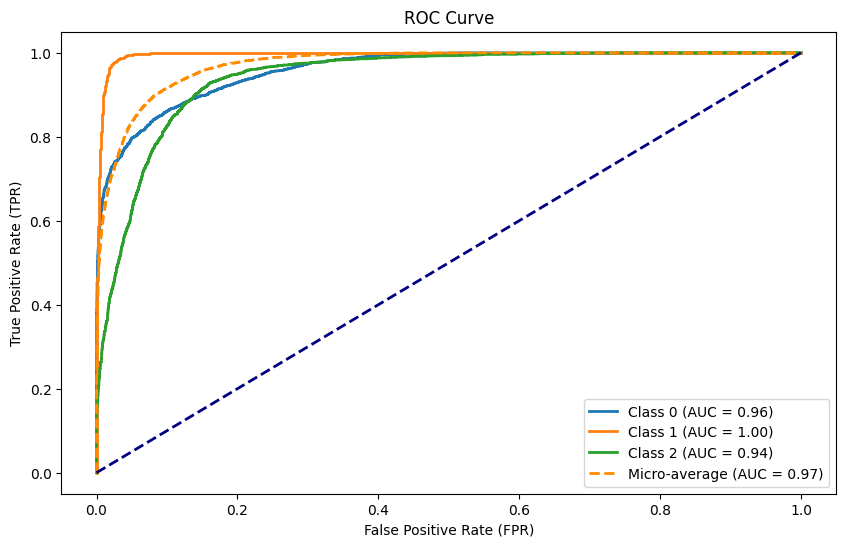

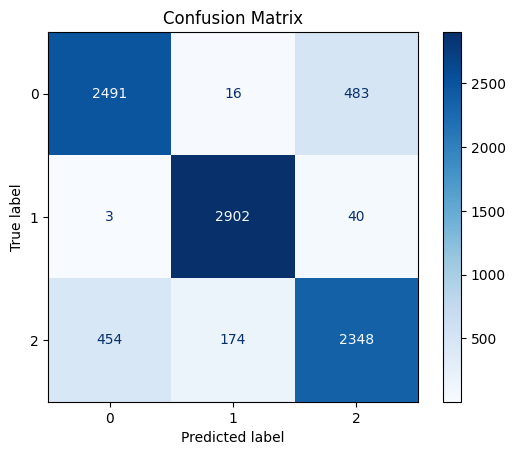

Confusion Matrix:
[[2491   16  483]
 [   3 2902   40]
 [ 454  174 2348]]


In [15]:
evaluate_classification_model(class_model, test_dataloader, 'cpu')

### Super Resolution

In [16]:
transform = None
val =  SRDataset("/kaggle/input/mae-sr-dataset-split/val/LR","/kaggle/input/mae-sr-dataset-split/val/HR", transform = transform)
test_sr_dataloader = DataLoader(val, batch_size = 512, shuffle = False)

In [17]:
mae = mae_vit_base(64)
ckpt = torch.load("/kaggle/input/weights-ml4sci-all/best_mae_vit_model_256emb_final.pth", map_location="cpu")
new_state_dict = {k.replace("module.", ""):ckpt[k] for k in ckpt.keys()}
mae.load_state_dict(new_state_dict, strict=True)

warnings.filterwarnings("ignore")
ckpt_path = "/kaggle/input/weights-ml4sci-all/best_sr_mae_model_FT_256emb.pth"
sr_model = load_model(SuperResolutionMAE(pretrained_mae=mae),ckpt_path)



Model loaded successfully from /kaggle/input/weights-ml4sci-all/best_sr_mae_model_FT_256emb.pth on cpu


In [18]:
avg_psnr, avg_ssim, avg_mse = evaluate_sr_model(sr_model, test_sr_dataloader, device='cpu')

Evaluating: 100%|██████████| 2/2 [01:28<00:00, 44.24s/batch]

Validation Results - PSNR: 33.7001, SSIM: 0.9681, MSE: 0.000427
